## Anomaly Detection in Time Series data using Python

### Anomaly Detection using (i) SD (ii) Seasonal mean (iii) Seasonal-Trend Decomposition using LOESS (STL) Approach 

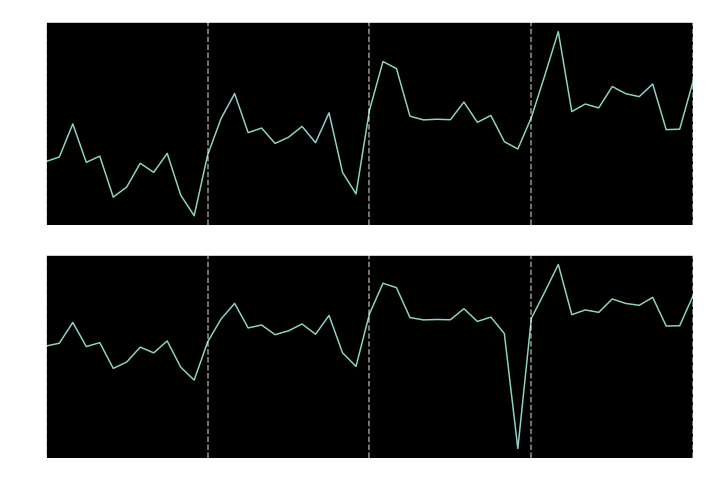

In [3]:
def dt_parser_func(dt_str):
    return( datetime.datetime.strptime( dt_str, '%Y-%m-%d' ) )

catfsh_Ser = pd.read_csv( 'datasets/catfish.csv', parse_dates= ['Date'], date_parser= dt_parser_func,
                          index_col= 'Date', squeeze= True )                                           

# infer the frequency of the data
catfsh_Ser = catfsh_Ser.asfreq( freq= pd.infer_freq(catfsh_Ser.index) )

# subset date
start_dt = datetime.datetime( 1996,1,1 );      end_dt = datetime.datetime( 2000,1,1 )
catfsh_Ser = catfsh_Ser.loc[ start_dt:end_dt ]

# plot
fg,ax = plt.subplots( 2,1, figsize= (10,7), sharex= True )

catfsh_Ser.plot( ax = ax[0] )
ax[0].set( title= 'Catfish Sales in 1000s of Pounds' )    

# introduce an Anomaly @ December 1 1998
catfsh_Ser[ datetime.datetime(1998,12,1) ] = 10000

catfsh_Ser.plot( ax = ax[1] )
ax[1].set( title= 'Catfish Sales in 1000s of Pounds - with Anomaly' )  

for e_yr in range( catfsh_Ser.index.min().year, catfsh_Ser.index.max().year+1 ):
    ax[0].axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.6)
    ax[1].axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.6)    

plt.tight_layout(); plt.show()

#### Confirming whether the Trend gets removed with 1st difference

Date
1996-02-01     291.0
1996-03-01    2091.0
1996-04-01   -2428.0
               ...  
1999-11-01   -2885.0
1999-12-01      28.0
2000-01-01    3040.0
Freq: MS, Name: Total, Length: 48, dtype: float64

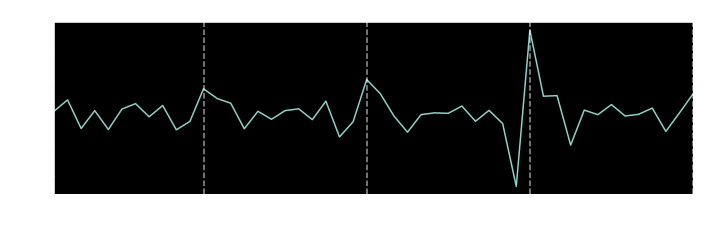

In [4]:
catfsh_diff = catfsh_Ser.diff().dropna()

# plot
fg,ax = plt.subplots( 1,1, figsize= (10,3.5) )

catfsh_diff.plot( ax = ax )
[  ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.6)\
   for e_yr in range( catfsh_diff.index.min().year, catfsh_diff.index.max().year+1 ) ]

ax.set( title= 'Catfish Sales - 1st difference' ); plt.tight_layout()   

catfsh_diff

#### Model fit prep

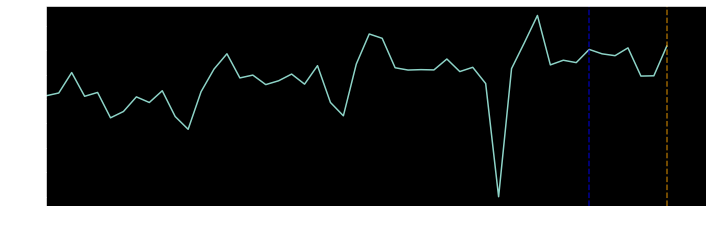

In [5]:
# Train/Test set

train_end = datetime.datetime( 1999,7,1 )
test_end = datetime.datetime( 2000,1,1 )

catfsh_TEST_df = catfsh_Ser[  train_end+timedelta(days=1) : test_end  ]

# plot
fg,ax = plt.subplots( 1,1, figsize= (10,3.5) )

catfsh_Ser.plot( ax = ax )

ax.axvline( x= train_end, linestyle= '--', alpha= 0.6, color= 'blue' )
ax.axvline( x= test_end, linestyle= '--', alpha= 0.6, color= 'orange' )
ax.set_xlim( right= test_end + timedelta(days=100) )

plt.tight_layout() 

#### model fit and prediction

In [6]:
order = ( 0,1,0 )
season_order = ( 1,0,1,12 )

yhat_roll = catfsh_TEST_df.copy()

for e_TrainEndDt in catfsh_TEST_df.index:
    
    catfsh_TRAIN_df = catfsh_Ser[ : e_TrainEndDt - timedelta(days=12) ]
    
    sarimaModel_fit = SARIMAX( catfsh_TRAIN_df, order= order, seasonal_order= season_order ).fit()
    
    yhat = sarimaModel_fit.forecast( steps= 1 )            # OR    
    yhat = sarimaModel_fit.predict( start= e_TrainEndDt )
   
    yhat_roll[e_TrainEndDt] = yhat
    
yi_yhat = catfsh_TEST_df - yhat_roll
yi_yhat_100 = yi_yhat/catfsh_TEST_df * 100

c:\python-projects\machine-learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\python-projects\machine-learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\python-projects\machine-learning\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


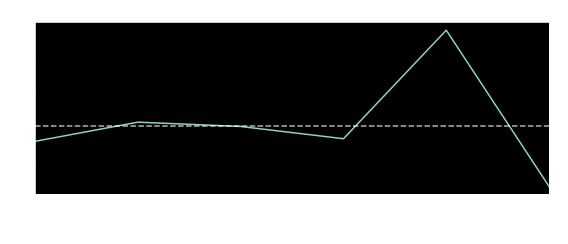

In [7]:
fg,ax = plt.subplots( 1,1, figsize= (8,3.5) )
yi_yhat_100.plot( ax = ax )
ax.axhline( y = 0, linestyle= '--', alpha= 0.7  )
ax.set( title= 'Residual percent plot' ); plt.tight_layout()

Mean Absolute % Error = 0.092
Root mean Squared error = 3209.44 


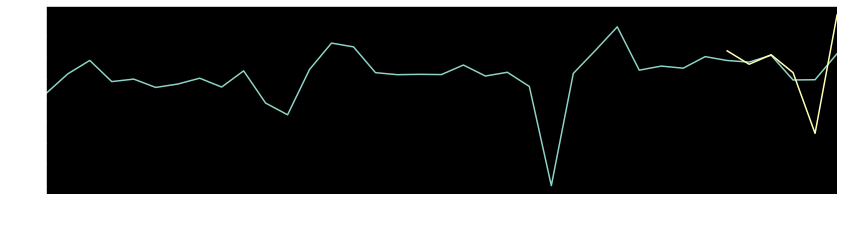

In [8]:
fg,ax = plt.subplots( 1,1, figsize= (12,3.5) )
catfsh_Ser['1997':].plot( ax= ax )   ;          yhat_roll.plot( ax = ax )
plt.tight_layout()

# model stats
print( f'Mean Absolute % Error = { round(np.mean(abs(yi_yhat/catfsh_TEST_df)),3) }\n\
Root mean Squared error = { round(np.sqrt(np.mean(yi_yhat**2)),2) } ' )

<br>

### Anomaly Detection Method I: Deviation Method

    Calculating expanding Standard Deviation starting from Yr 1 data, then Yr 1 + Yr 2 data, then Yr 1 + Yr 2 + Yr 3 data and finally Yr 1 + Yr 2 + ... + Yr n data

In [9]:
catfsh_Expanding_SD = pd.Series( dtype= float, index= catfsh_Ser.index )

# expanding SD
for e_dt in catfsh_Expanding_SD.index:
    catfsh_Expanding_SD.loc[e_dt] = catfsh_Ser.loc[ : e_dt ].std()    

# expanding SD's diff percent 
catfsh_Expanding_SD_diff = catfsh_Expanding_SD.diff().dropna()[1:]

catfsh_Expanding_SD_diff

Date
1996-04-01   -139.611236
1996-05-01   -145.877037
1996-06-01    458.946561
                 ...    
1999-11-01    -32.996588
1999-12-01    -31.896381
2000-01-01      6.194821
Freq: MS, Length: 46, dtype: float64

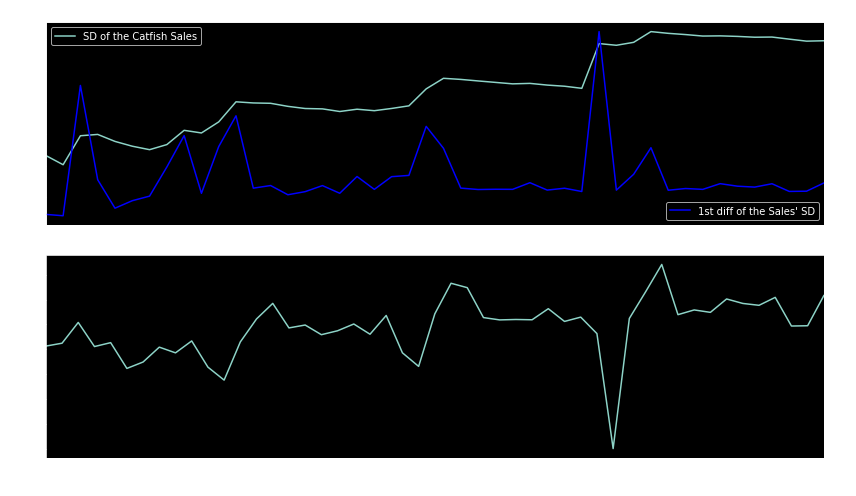

In [10]:
fg,ax = plt.subplots( 2,1, figsize= (12,7) )

catfsh_Expanding_SD.plot( ax= ax[0], label= 'SD of the Catfish Sales' )

ax_ = ax[0].twinx()
catfsh_Expanding_SD_diff.plot( ax= ax_, color= 'blue', label= "1st diff of the Sales' SD"  )

catfsh_Ser.plot( ax= ax[1], label= 'Catfish Sales' )

ax[0].legend(); ax_.legend( loc= 'lower right' )
ax[0].set( title= "Sales' SD and SD's 1st difference" );   ax[1].set( title= "Catfish Sales" )
plt.tight_layout()

### Anomaly Detection Method II: Seasonal Method

    Calculating expanding Standard Deviation starting from Yr 1 data, then Yr 1 + Yr 2 data, then Yr 1 + Yr 2 + Yr 3 data and finally Yr 1 + Yr 2 + ... + Yr n data

In [15]:
catfsh_Monthly_SD = catfsh_Ser.groupby( by= catfsh_Ser.index.month ).agg(np.std)

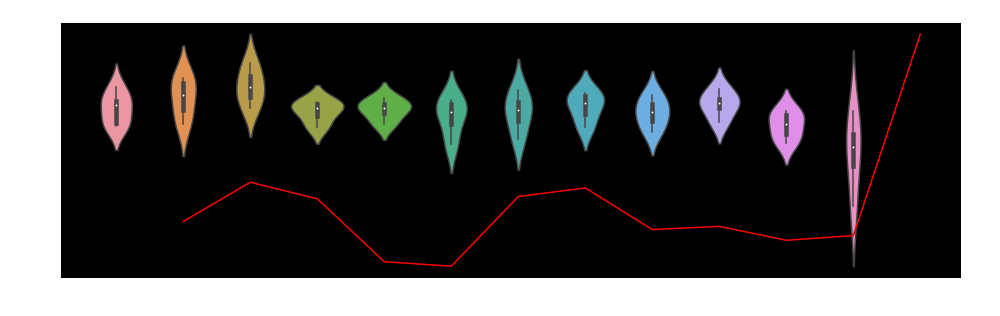

In [23]:
# plot
fg,ax = plt.subplots( 1,1, figsize= (14,4.5), sharex= True )

ax_ = ax.twinx()

sns.violinplot( x=catfsh_Ser.index.month, y= catfsh_Ser, ax= ax  )
catfsh_Monthly_SD.plot( ax = ax_, color= 'red' )

ax.set( title= 'Violinplot for Catfish monthly sales and Lineplot for the Sales monthly SD' )  

plt.tight_layout(); plt.show()

So, from the above combined plot, we know that the anomaly occurs in December.But we need to find out which year's December?

In [26]:
catfsh_Dec = catfsh_Ser.loc[ catfsh_Ser.index.month == 12 ]
catfsh_Dec

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Freq: 12MS, Name: Total, dtype: int64

In [31]:
min_SD = 999999999

for e_dt in catfsh_Dec.index:
    other_data_SD = catfsh_Dec[ catfsh_Dec.index != e_dt ].std()
    print(other_data_SD)
    
    if other_data_SD < min_SD:
        min_SD = other_data_SD
        anomalyData_dt = e_dt
        
# OR use following efficient code-approach

6302.810272674668
6199.643323073783
2846.925593220401
4434.938706829366


In [61]:
catfsh_Dec_XOR_SD = [ catfsh_Dec[ catfsh_Dec.index != e_dt ].std() for e_dt in catfsh_Dec.index ]
    
minIdx = catfsh_Dec_XOR_SD.index( min(catfsh_Dec_XOR_SD) )

anomalyData_dt =  catfsh_Dec[[minIdx]]

anomalyData_dt

Date
1998-12-01    10000
Freq: 12MS, Name: Total, dtype: int64

#### Fixing the Anomaly by
        replacing the anomaly value with the mean of other months 

<br>

###  Robust Anomaly Detection III:  Seasonal-Trend Decomposition using LOESS (STL) Approach 

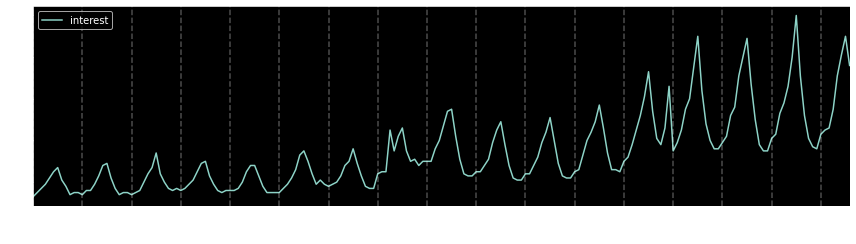

In [73]:
icei_df = pd.read_csv( 'datasets/ice_cream_interest.csv', parse_dates= [0], index_col= 0  )
icei_df = icei_df.asfreq( freq= pd.infer_freq( index= icei_df.index ) )

icei_Ser = icei_df.squeeze()

fg,ax = plt.subplots( figsize= (12,3.5) )
icei_df.plot( ax= ax )

[ ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
  for e_yr in range( icei_df.index.min().year, icei_df.index.max().year+1 )  ];

plt.tight_layout()

     Visually, the Anomaly exist between year 2011-2012 & b/w 2016-2017.

In [74]:
from statsmodels.tsa import seasonal

In [84]:
stl_fit = seasonal.STL( icei_df ).fit()

seasonal_Ser, trend_Ser, resid_Ser = stl_fit.seasonal, stl_fit.trend, stl_fit.resid

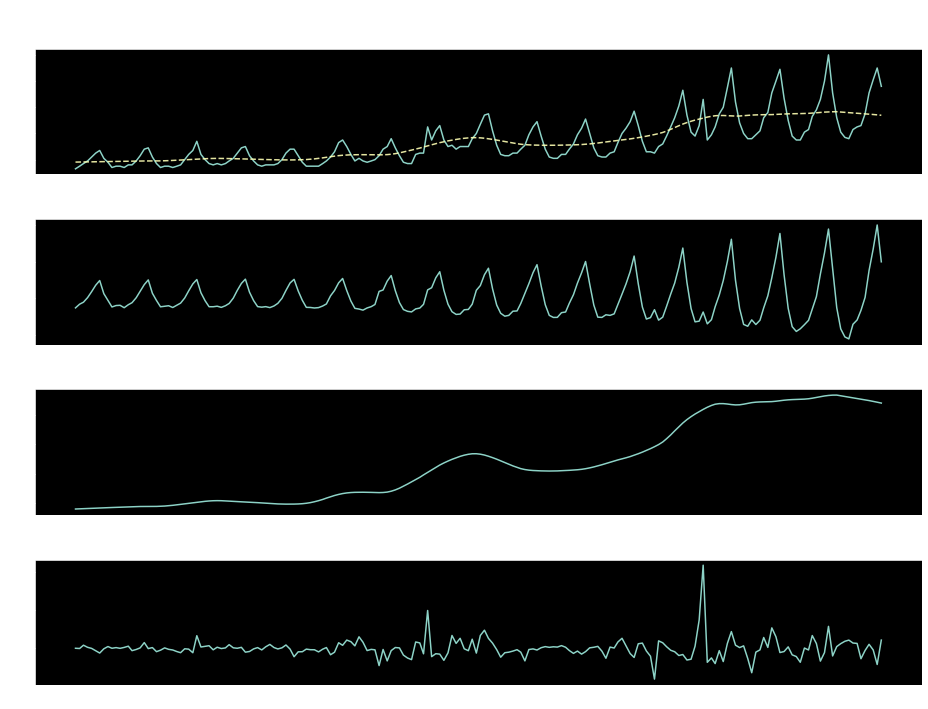

In [128]:
## plots

dataToPlot_ls = [ icei_Ser, seasonal_Ser, trend_Ser, resid_Ser ]
title_ls= [ 'Original Timeseries', 'Seasonal decomposition', 'Trend decomposition', 'Residual decomposition' ]

row_num = len( dataToPlot_ls )

fg,ax = plt.subplots( nrows= row_num, ncols= 1, figsize= (13,2.5*row_num) )

for idx,(e_ax,e_data,e_title) in enumerate(  zip(ax.flatten(),dataToPlot_ls, title_ls)  ):
    e_ax.plot( e_data )
    e_ax.set_title( e_title, fontsize= 14 )

ax[0].plot( dataToPlot_ls[2], linestyle= '--', alpha= 0.9 )    
fg.suptitle( 'Seasonal-Trend Decomposition', fontsize= 17 )   

plt.tight_layout()

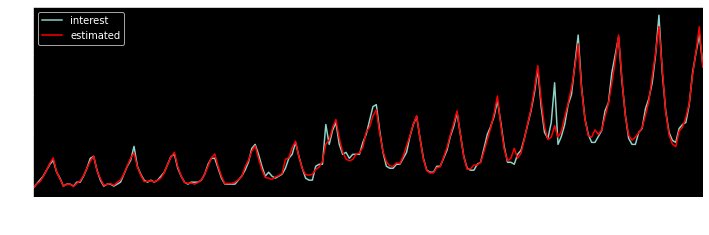

In [116]:
y_est = trend_Ser + seasonal_Ser

fg,ax = plt.subplots( figsize= (12,3.5) )

icei_df.plot( ax= ax, label= 'Original' )
y_est.plot( ax= ax, label= 'estimated', color= 'red' )

ax.legend(); plt.show()


#### Anomaly detection based on set Residual value

In [130]:
resid_mu, resid_SD = resid_Ser.mean(), resid_Ser.std()

threshold = 3

resid_lowerCI, resid_upperCI = resid_mu - threshold*resid_SD ,  resid_mu + threshold*resid_SD

In [142]:
resid_Ser.index.min()

Timestamp('2004-01-01 00:00:00', freq='MS')

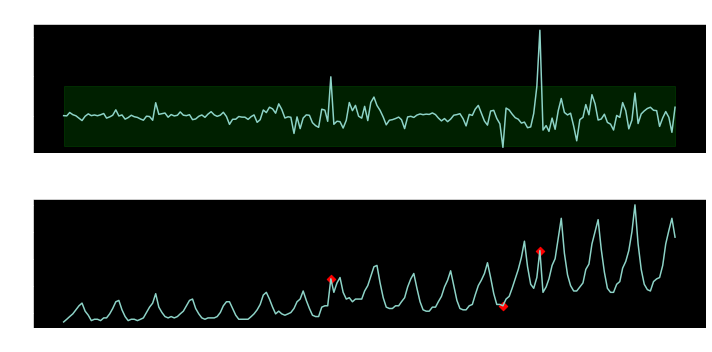


Anomalies:

month
2011-04-01    45
2015-12-01    25
2016-12-01    66
Name: interest, dtype: int64


In [173]:
fg,(ax1,ax2) = plt.subplots( 2,1, figsize= (10,5) )

from datetime import datetime as dtm

ax1.plot( resid_Ser )
ax1.fill_between( x= [resid_Ser.index.min(), resid_Ser.index.max()], y1= resid_lowerCI, y2= resid_upperCI,
                 color= 'g', alpha= 0.25  )
ax1.set_title( 'Residual plot with threshold', fontsize= 15 )

# the anomaly ones
ice_anomalyPt_Ser = icei_Ser[  ( resid_Ser < resid_lowerCI ) | ( resid_Ser > resid_upperCI ) ]

ax2.plot( icei_Ser )
ax2.scatter( x= ice_anomalyPt_Ser.index, y= ice_anomalyPt_Ser, color= 'red', marker= 'D'  )
ax2.set_title( 'Origina TimeSeries with Anamalies indicated', fontsize= 15 )

plt.tight_layout( );plt.show()

print( f'\nAnomalies:\n\n{ice_anomalyPt_Ser}' )

### Libraries

In [1]:
# %reset
# import utility_madhur



#   &thinsp;   &nbsp;   &ensp;   &emsp;

#  import warnings; warnings.filterwarnings( action= 'ignore' )

# # to check whether a string is a python keyword
# import keyword
# keyword.iskeyword('str')

from IPython.core.display import display, HTML
display(  HTML( '<style>.container { width:100% !important; }</style>' )  )

import warnings
get_ipython().run_line_magic('config', 'Completer.use_jedi = False')
import os, random, time

import pandas as pd
# import pandas_datareader as pdr
import numpy as np,  seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn
import missingno as msno
import h5py, math, scipy, statsmodels
# import xlrd
import ipywidgets as widgets

import datetime, dateutil
from datetime import timedelta


# import fuzzywuzzy
# from fuzzywuzzy import fuzz, process
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.gridspec import GridSpec
from pylab import rcParams

# plt.style.use('Solarize_Light2')
plt.style.use('dark_background')

from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa import arima_model, arima_process, arima
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from arch import arch_model
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import pmdarima as pm
import joblib

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# import yfinance as yf

get_ipython().run_line_magic('matplotlib', 'inline')

np.random.seed(1) # set a seed so that the results are consistent

## Set Jupyter notebook display options for pandas

pd.set_option('display.max_columns', None)
# pd.options.display.max_columns = 8
# pd.set_option('display.max_rows', None)
pd.options.display.max_rows = 5

# <h3><p style= 'text-align:center;'>Img title</p></h3>
# <img src= 'images/split-apply-combine.png' style= 'width:917px;height:437px;'>

# m, wd, ht = 2, 990, 576; ( wd/m, ht/m  )


In [2]:
import re

def clean_text(str_var):    

    '''
    clean the text, useful for column header
    Arguments:
    str_var -- a string variable of any size

    Return:
    str_modf -- a cleaned string variable
    
    '''
    
    # lower case and revome begin & end space
    str_modf = str_var.lower().strip()    
    # replace all non word chars ( everything except letters and nos )
    str_modf = re.sub( pattern= r'[^\w\s]', repl= '_', string= str_modf )    
    # replace all runs of whitespace with '_'
    str_modf = re.sub( pattern= r'\s+', repl= '_', string= str_modf )    
    # repalce > 1 consecutive '_'
    str_modf = re.sub( pattern= r'[__]+', repl= '_', string= str_modf )   
    
    # remove begining and trailing _ : '__any_word____' --> 'any_word'
    def _remove_begin_end_(str_var):
        while True:
            if str_var[-1] == '_':
                str_var = str_modf[:len(str_modf)-1]
            else:                
                break                
        while True:
            if str_var[0] == '_':                            
                str_var = str_modf[1:len(str_modf)]
            else:                
                break                
        return(str_var)
    
    str_modf = _remove_begin_end_(str_modf)        
    
    return(str_modf)    

clean_colm_name = lambda df: [ clean_text(e_cNm) for e_cNm in df.columns ]

def set_Xticks_for_axes( ax_ls, minor_major = (10,50) ):
    '''
    sets the x axis' major & minor ticks distance
    ax = the axis obj, could be single ax obj, a list of axis objs, np array of axis objs
    minor_major = tuple for major and minor distance for x axis    
    '''
    from matplotlib.ticker import ( MultipleLocator, AutoMinorLocator )

    for e_ax in np.array(ax_ls).flatten():      #<-- making all list or single ax obj into np.array & then flattening it
        e_ax.xaxis.set_minor_locator( MultipleLocator( minor_major[0] ) )
        e_ax.xaxis.set_major_locator( MultipleLocator( minor_major[1] ) )
        
def set_ticks_for_axes( ax_ls, x_y= 'x', minor_major= (10,50) ):
    '''
    sets the x axis' major & minor ticks distance
    x_y = the x or y axis
    ax = the axis obj, could be single ax obj, a list of axis objs, np array of axis objs
    minor_major = tuple for major and minor distance for x axis    
    '''
    from matplotlib.ticker import ( MultipleLocator, AutoMinorLocator )
    
    if x_y == 'x' or x_y != 'y':
        for e_ax in np.array(ax_ls).flatten():      #<-- making all list or single ax obj into np.array & then flattening it
            e_ax.xaxis.set_minor_locator( MultipleLocator( minor_major[0] ) )
            e_ax.xaxis.set_major_locator( MultipleLocator( minor_major[1] ) )
    elif x_y == 'y':
        for e_ax in np.array(ax_ls).flatten():      #<-- making all list or single ax obj into np.array & then flattening it
            e_ax.yaxis.set_minor_locator( MultipleLocator( minor_major[0] ) )
            e_ax.yaxis.set_major_locator( MultipleLocator( minor_major[1] ) )
            
def adfuller_test( ser ):
    adfuller_tests_result = adfuller( ser )
    print( '\nADF Statistic (tValue): {var1:5.2f}    |    pValue: {var2:4.2f}'\
           .format( var1=adfuller_tests_result[0], var2= adfuller_tests_result[1] )  )
    if ( adfuller_tests_result[1] >= 0.05 ): print( 'The TimeSeries is NOT Stationary but a Random Walk' )
    else: print( 'The TimeSeries is Stationary not a Random Walk' )
    return(  [ np.round(adfuller_tests_result[0],3), np.round(adfuller_tests_result[1],3) ] )

def adfuller_test_str( ser ):
    adfuller_tests_result = adfuller( ser )
    
    to_print = 'ADF Statistic (tValue): {var1:5.2f}    |    pValue: {var2:4.2f}'\
               .format( var1=adfuller_tests_result[0], var2= adfuller_tests_result[1] )

    if ( adfuller_tests_result[1] >= 0.05 ):   to_print += '   |   The TimeSeries is NOT Stationary but a Random Walk'
    else:                                      to_print += '   |   The TimeSeries is Stationary not a Random Walk'
    
    return( to_print )

from IPython.display import display_html

def display_side_by_side(*args):
    '''
    func to display pandas dfs side by side
    input: dfs
    '''
    html_str = ''
    for df in args:
        html_str += df.to_html( )
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )  
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )   
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )        
    display_html(  html_str.replace( "table", "table style= 'display:inline'" ),
                   raw=True  )
    
def display_side_by_side_head(*args):
    '''
    func to display pandas dfs side by side
    input: dfs
    '''
    html_str = ''
    for df in args:
        html_str += df.head(5).to_html( )
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False ) 
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False )    
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False )        
    display_html(  html_str.replace( "table", "table style= 'display:inline'" ),
                   raw=True  )